#### Import the relevant libraries

In [5]:
import pandas as pd 
import numpy as np
import math
import keras
import tensorflow as tf
import progressbar
import os
from os import listdir
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization

# Functions

$\texttt{balance_data}$: This function allows us to balance the dataset by using the oversampling technique based on the predictor variables.

In [2]:
def balance_data(class_data, nbins):

    from matplotlib import pyplot as plt
    y = class_data[:,0]
    n, edges, _ = plt.hist(y, nbins, color = 'indianred', alpha=0.5, label='Osiris')
    n_max = int(n.max())
    data = []
    bar = progressbar.ProgressBar(maxval=len(class_data), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                       progressbar.Percentage(), 
                                       " of {0}".format(len(class_data))])
    bar.start()
    for k, class_ in enumerate(class_data):
        for i in range(len(n)):
            edges_min = edges[i]
            edges_max = edges[i+1]
            if class_[0] > edges_min and class_[0] < edges_max:
                for j in range(int(n_max/(n[i]))):
                    data.append(class_)
                break
        bar.update(k+1)
    bar.finish()
    plt.title('Balanced data ')
    return np.array(data)

$\texttt{prepare_data}$: split the dataset in $\text{[x_train, y_train, x_val, y_val] }$ where yy are the targets and xx are inputs

In [3]:
def prepare_data(class_data): 
    np.random.shuffle(class_data)
    y = class_data[:,0]
    x = class_data[:,1:10]
    train_split = 0.85
    train_limit = int(len(y)*train_split)
    print("Training sample of: {0} \nValuation sample: {1}".format(train_limit, len(y)-train_limit))
    x_train = x[:train_limit]
    x_val = x[train_limit:]
    y_train = y[:train_limit]
    y_val = y[train_limit:]
    if np.isnan(np.min(y)) == False:
        return x_train, y_train, x_val, y_val

$\texttt{plot_histo}$: Plots the data before balancing

In [17]:
def plot_histo(x, y, bins,logscale):
    y = np.array(y)
    plt.hist(y, bins, color = 'indianred', alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Probability')
    if logscale == 1:
        plt.yscale('log')
    plt.title('Unbalanced data ')
    plt.show()

$\texttt{plot_history}$: Plots the loss function and the Kullback–Leibler divergence of every epoch.  The Kullback–Leibler divergence, (also called relative entropy), is a measure of how one probability distribution is different from a second, reference probability distribution.

In [4]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['kullback_leibler_divergence']
    val_accuracy = history.history['val_kullback_leibler_divergence']


    epochs = range(1, len(loss) + 1)
    fig, ax1 = plt.subplots()

    l1 = ax1.plot(epochs, loss, 'bo', label='Training loss')
    vl1 = ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (mape)')

    ax2 = ax1.twinx()
    ac2= ax2.plot(epochs, accuracy, 'o', c="red", label='Training KL div.')
    vac2= ax2.plot(epochs, val_accuracy, 'r', label='Validation KL div.')
    ax2.set_ylabel('Kullback Leibler divergence')

    lns = l1 + vl1 + ac2 + vac2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc="center right")
    fig.tight_layout()
    fig.show()

$\texttt{data_vel}$: create a dataset for a specific initial velocity

In [145]:
def data_vel(v_i): 
    v= np.random.uniform(v_i,v_i, (observations))
    x= np.linspace(0,100, (observations)) #gcm^-2
    generated_data1 = np.array([multiple(v,x),v,x])
    data1 = np.transpose(generated_data1)
    targets=data1[:,:1]
    inputs = data1[:,1:]
    return targets, inputs

$\texttt{data_vel_range}$: create a dataset for a specific range of initial velocities

In [117]:
def data_vel_range(vmin,vmax): 
    v=np.random.uniform(vmin, vmax, (observations))
    x= np.random.uniform(0,100, (observations)) #gcm^-2
    generated_data1 = np.array([multiple(v,x),v,x])
    data1 = np.transpose(generated_data1)
    x0_train, y0_train, x0_val, y0_val = prepare_data(data1)
    return x0_train, y0_train, x0_val, y0_val

# Creating the dataset

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\mean}[1]{\left\langle{#1}\right\rangle}
$
### Multiple Scattering

The Rutherford differential cross section describes the interaction between a particle of charge $z$ and an atomic nucleus
with atomic number $Z$, as a function of the scattering angle $\theta$:
\begin{equation}
\frac{d \sigma}{d\Omega} = \Big(\frac{zZe^2}{16\pi\epsilon_0E_k}\Big)^2 \times \frac{1}{\sin^4(\theta/2)} 
\end{equation}
Here $E_k$ denotes the kinetic energy of the charged particle.

From the Rutherford formulation it is clear that the cross section diverges at small angles. This implies that the average scattering angle is $\mean{\theta}  = 0$ . Under the hypothesis that a particle undergoes multiple independent scatterings
in a material, it is reasonable to assume the mean scattering angle to be Gaussian distributed. 
###### So, the standard deviation (or the variance) of this Gaussian is the relevant experimental quantity, as a beam of particles traveling in matter will somehow be “spread” by that amount.

And the expression is:
\begin{equation}
\sqrt{\mean{\theta^2}} = z \frac{E_s}{p \nu}\sqrt{\frac{x}{X_0}}
\end{equation}
Where $z$ is the charge of the particle being scattered, $E_s = 21MeV$, $X_0$ is the material's radiation length, $\rho$ is the scattered particle's momentum, $x$ is the material thickness and $\nu$ the particle's initial velocity.

$\texttt{multiple}$: This function receives the initial velocity and the material thickness and devolves the standard deviation according to Rutherford Multiple Scattering

In [7]:
def multiple(v, x): 
    z= 2 # For an alpha particle
    Es = 21 # MeV
    # For Au
    X0 = 6.46 # gcm^-2
    Z = 79   
    #mass of an alpha particle
    m= 938.27*2+939.56*2 # MeV
    #momentum
    p = m*v
    
    return z*Es*np.sqrt(x/X0)/(p*v)

In [8]:
multiple (0.9, 3)

0.009408542936882177

### Generate the dataset

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\mean}[1]{\left\langle{#1}\right\rangle}
$   
The structure of the data set is as follows: $\newline$
 \begin{equation}
 \Big[\mean{\theta^2} \text{, v , x} \Big]
 \end{equation}
 
Where  $\mean{\theta^2}$ is the standard deviation of the angular distribution (the target of our network), $v$ is the initial velocity and $x$ is the thickness of the material. 

In [9]:
# First, we should declare a variable containing the size of the training set we want to generate.
observations = 100000

# We will work with two variables as inputs.
# We generate them randomly, drawing from an uniform distribution.
v= np.random.uniform(0,1, (observations)) #C
x= np.random.uniform(0,100, (observations)) #gcm^-2

generated_data = np.array([multiple(v,x),v,x])
data = np.transpose(generated_data)

### Probability distributions (non balanced)

In [11]:
x0_train, y0_train, x0_val, y0_val = prepare_data(data)

Training sample of: 85000 
Valuation sample: 15000


In [12]:
print(x0_train.shape)
print(y0_train.shape)
print(x0_val.shape)
print(y0_val.shape)

(85000, 2)
(85000,)
(15000, 2)
(15000,)


No handles with labels found to put in legend.


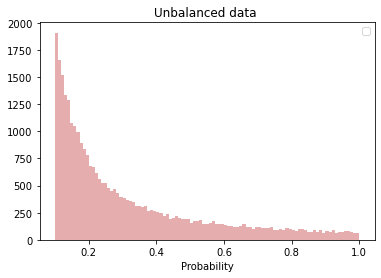

In [18]:
bins = np.linspace(0.1, 1, 100)
plot_histo(x0_train,y0_train,bins,0)

### Balancing of the data

[==============================================================] 100% of 100000


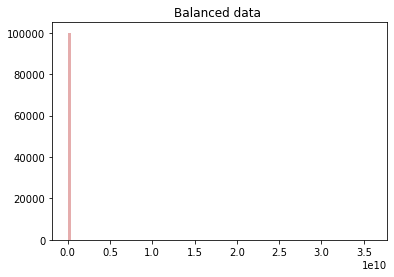

In [19]:
data_b = balance_data(data, 100)

### Split the data
85% for train and 15% for validation

In [20]:
x0_train, y0_train, x0_val, y0_val = prepare_data(data_b)

Training sample of: 339985 
Valuation sample: 59998


In [21]:
print(x0_train.shape)
print(y0_train.shape)
print(x0_val.shape)
print(y0_val.shape)

(339985, 2)
(339985,)
(59998, 2)
(59998,)


## Model Building

In [22]:
def build_model() :
    model = models.Sequential()
    model.add (BatchNormalization(input_dim = 2))
    model.add (layers.Dense (16 , activation = "sigmoid"))
    model.add (layers.Dense (32, activation = "relu"))
    model.add (layers.Dense (64, activation = "relu"))
    model.add (layers.Dense (32, activation = "relu"))
    model.add (layers.Dense (16 , activation = "sigmoid"))
    model.add (layers.Dense (1))
    model.compile(optimizer = "adam" , loss = 'mape' , metrics = [tf.keras.metrics.KLDivergence()])
    return model

In [29]:
model = build_model ()
history0 = model.fit ( x0_train, y0_train, epochs = 200, batch_size = 10000 , validation_data = (x0_val, y0_val) )

Epoch 1/200
34/34 [==============================] - 2s 30ms/step - loss: 247.6430 - kullback_leibler_divergence: 0.5654 - val_loss: 94.4552 - val_kullback_leibler_divergence: 1.6696
Epoch 2/200
34/34 [==============================] - 1s 24ms/step - loss: 95.9170 - kullback_leibler_divergence: 1.6979 - val_loss: 104.7056 - val_kullback_leibler_divergence: 1.4475
Epoch 3/200
34/34 [==============================] - 1s 21ms/step - loss: 87.4192 - kullback_leibler_divergence: 1.4969 - val_loss: 103.6754 - val_kullback_leibler_divergence: 1.3637
Epoch 4/200
34/34 [==============================] - 1s 21ms/step - loss: 86.2735 - kullback_leibler_divergence: 1.4108 - val_loss: 101.8358 - val_kullback_leibler_divergence: 1.3426
Epoch 5/200
34/34 [==============================] - 1s 24ms/step - loss: 85.9734 - kullback_leibler_divergence: 1.3589 - val_loss: 100.3481 - val_kullback_leibler_divergence: 1.2793
Epoch 6/200
34/34 [==============================] - 1s 22ms/step - loss: 85.1521 - k

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 2)                 8         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_13 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

<ipython-input-4-d87e745cb2b5>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


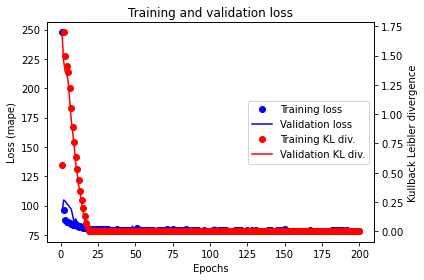

In [31]:
plot_history(history0)

### Prediction

In [32]:
y_pred0 = model.predict(x0_val)

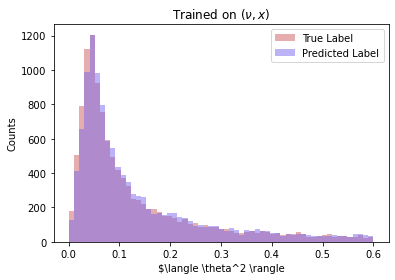

In [35]:
from matplotlib import pyplot
y0_val = np.array(y0_val)
bins = np.linspace(0.0004, 0.6, 60)
pyplot.hist(y0_val, bins, color = 'indianred', alpha=0.5, label='True Label')
pyplot.hist(y_pred0, bins, color = 'mediumslateblue', alpha=0.5, label='Predicted Label')
#pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.xlabel('$\\langle \\theta^2 \\rangle')
pyplot.ylabel('Counts')
pyplot.title('Trained on ($ \\nu , x $)')
pyplot.show()

### Predictions for $\langle \theta^2 \rangle$ vs $  (x)$

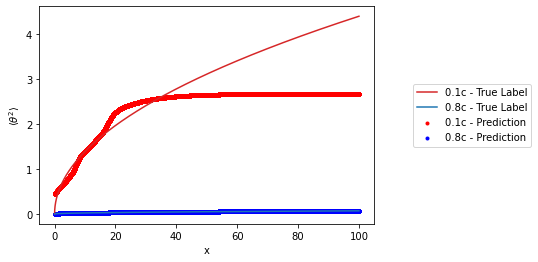

In [146]:
targets_v1, inputs_v1 = data_vel(0.1)
pred_targets_v1 = model.predict(inputs_v1)

targets_v2, inputs_v2 = data_vel(0.8)
pred_targets_v2 = model.predict(inputs_v2)

fig, ax = plt.subplots()

ax.scatter(inputs_v1[:,1], pred_targets_v1, marker='.', label='0.1c - Prediction', c='red')
ax.plot(inputs_v1[:,1], targets_v1, label='0.1c - True Label', c='tab:red')

ax.scatter(inputs_v2[:,1], pred_targets_v2, marker='.', label='0.8c - Prediction', c='b')
ax.plot(inputs_v2[:,1], targets_v2, label='0.8c - True Label', c='tab:blue')

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plt.savefig('prediction_multipleScattering.png',bbox_inches='tight')

plt.xlabel('x')
plt.ylabel('$\\langle \\theta^2 \\rangle$')
plt.show()

## Transfer Learning

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. <br>
So, we will divide the dataset into two parts: the first has velocities from $0$ to $0.5c$ and then the second group has velocities from $0$ to $c$.

In [129]:
x1_train, y1_train, x1_val, y1_val= data_vel_range(0, 0.5)

Training sample of: 85000 
Valuation sample: 15000


In [130]:
model_TL = build_model()
historyTL1 = model_TL.fit ( x1_train, y1_train, epochs = 200, batch_size = 10000 , validation_data = (x1_val, y1_val) )

Epoch 1/200
9/9 [==============================] - 2s 51ms/step - loss: 183.1866 - kullback_leibler_divergence: 8.7746 - val_loss: 129.4054 - val_kullback_leibler_divergence: 8.6934
Epoch 2/200
9/9 [==============================] - 0s 23ms/step - loss: 103.9895 - kullback_leibler_divergence: 4.0207 - val_loss: 73.0792 - val_kullback_leibler_divergence: 0.5562
Epoch 3/200
9/9 [==============================] - 0s 25ms/step - loss: 72.0152 - kullback_leibler_divergence: 0.4773 - val_loss: 97.1354 - val_kullback_leibler_divergence: 0.3468
Epoch 4/200
9/9 [==============================] - 0s 24ms/step - loss: 64.4967 - kullback_leibler_divergence: 0.5405 - val_loss: 67.5206 - val_kullback_leibler_divergence: 0.5527
Epoch 5/200
9/9 [==============================] - 0s 24ms/step - loss: 58.7136 - kullback_leibler_divergence: 0.6108 - val_loss: 82.6523 - val_kullback_leibler_divergence: 0.3922
Epoch 6/200
9/9 [==============================] - 0s 22ms/step - loss: 54.3589 - kullback_leible

<ipython-input-4-d87e745cb2b5>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


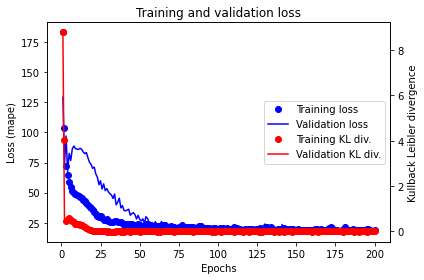

In [131]:
plot_history(historyTL1)

In [132]:
targets_v3, inputs_v3 = data_vel(0.2)
pred_targets_v3 = model_TL.predict(inputs_v3)

In [133]:
x2_train, y2_train, x2_val, y2_val= data_vel_range(0, 1)

Training sample of: 85000 
Valuation sample: 15000


In [134]:
model_TL.trainable = True
historyTL2 = model_TL.fit ( x2_train, y2_train, epochs = 200, batch_size = 10000 , validation_data = (x2_val, y2_val) )

Epoch 1/200
9/9 [==============================] - 0s 26ms/step - loss: 137.6267 - kullback_leibler_divergence: 0.0456 - val_loss: 73.4079 - val_kullback_leibler_divergence: 0.3878
Epoch 2/200
9/9 [==============================] - 0s 20ms/step - loss: 63.8836 - kullback_leibler_divergence: 0.1235 - val_loss: 87.3306 - val_kullback_leibler_divergence: 0.4479
Epoch 3/200
9/9 [==============================] - 0s 20ms/step - loss: 45.2308 - kullback_leibler_divergence: 0.1369 - val_loss: 82.3938 - val_kullback_leibler_divergence: 0.3247
Epoch 4/200
9/9 [==============================] - 0s 20ms/step - loss: 32.0246 - kullback_leibler_divergence: 0.0575 - val_loss: 74.6637 - val_kullback_leibler_divergence: 0.2070
Epoch 5/200
9/9 [==============================] - 0s 22ms/step - loss: 21.2375 - kullback_leibler_divergence: 0.0013 - val_loss: 48.7402 - val_kullback_leibler_divergence: 0.1335
Epoch 6/200
9/9 [==============================] - 0s 21ms/step - loss: 16.7040 - kullback_leibler_

<ipython-input-4-d87e745cb2b5>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


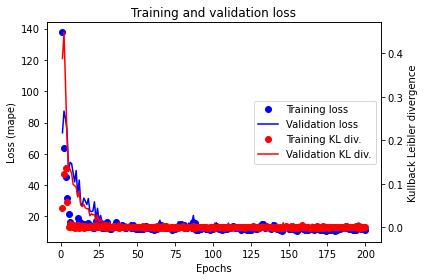

In [135]:
plot_history(historyTL2)

In [136]:
targets_v4, inputs_v4 = data_vel(0.1)
pred_targets_v4 = model_TL.predict(inputs_v4)

targets_v5, inputs_v5 = data_vel(0.8)
pred_targets_v5 = model_TL.predict(inputs_v5)

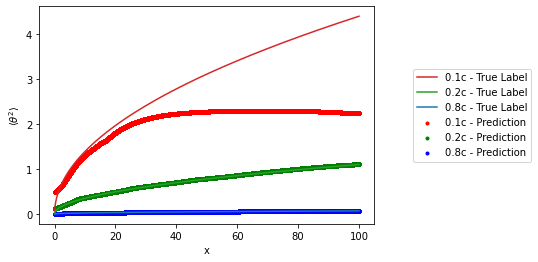

In [137]:
fig, ax = plt.subplots()

ax.scatter(inputs_v4[:,1], pred_targets_v4, marker='.', label='0.1c - Prediction', c='red')
ax.plot(inputs_v4[:,1], targets_v4, label='0.1c - True Label', c='tab:red')

ax.scatter(inputs_v3[:,1], pred_targets_v3, marker='.', label='0.2c - Prediction', c='g')
ax.plot(inputs_v3[:,1], targets_v3, label='0.2c - True Label', c='tab:green')

ax.scatter(inputs_v5[:,1], pred_targets_v5, marker='.', label='0.8c - Prediction', c='b')
ax.plot(inputs_v5[:,1], targets_v5, label='0.8c - True Label', c='tab:blue')

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plt.savefig('prediction_multipleScattering.png',bbox_inches='tight')

plt.xlabel('x')
plt.ylabel('$\\langle \\theta^2 \\rangle$')
plt.show()

##  Comparison of both the Gaussians (from prediction & the analytical calculation)

In [138]:
def predictAgularSD(model, velocity, length):
    feat = np.array([[velocity,length]])
    prediction = model.predict(feat)
    return prediction[0][0]

In [139]:
predictAgularSD(model_TL, 0.1, 3)

0.6911083

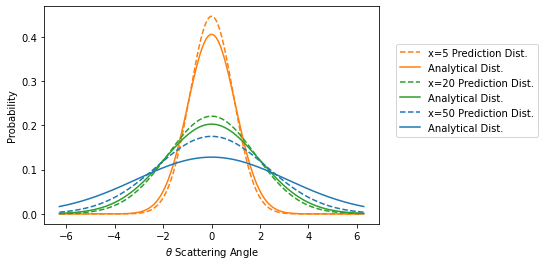

In [142]:
theta = np.linspace(-2*np.pi,2*np.pi,1000)


predicted_sd_x5 = predictAgularSD(model_TL, 0.1, 5)
true_sd_x5 = multiple(0.1, 5)

plt.plot(theta, 1/(predicted_sd_x5 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * predicted_sd_x5**2) ),
        linestyle='dashed', c='tab:orange', label='x=5 Prediction Dist.')
plt.plot(theta, 1/(true_sd_x5 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * true_sd_x5**2) ),
        c='tab:orange', label='Analytical Dist.')



predicted_sd_x20 = predictAgularSD(model_TL, 0.1, 20)
true_sd_x20 = multiple(0.1, 20)

plt.plot(theta, 1/(predicted_sd_x20 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * predicted_sd_x20**2) ),
        linestyle='dashed', c='tab:green', label='x=20 Prediction Dist.')
plt.plot(theta, 1/(true_sd_x20 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * true_sd_x20**2) ),
        c='tab:green', label='Analytical Dist.')

predicted_sd_x50 = predictAgularSD(model_TL, 0.1, 50)
true_sd_x50 = multiple(0.1, 50)

plt.plot(theta, 1/(predicted_sd_x50 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * predicted_sd_x50**2) ),
        linestyle='dashed', c='tab:blue', label='x=50 Prediction Dist.')
plt.plot(theta, 1/(true_sd_x50 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * true_sd_x50**2) ),
        c='tab:blue', label='Analytical Dist.')


plt.xlabel('$\\theta$ Scattering Angle')
plt.ylabel('Probability')
plt.legend(loc=[1.05,0.4])
plt.show()